# Automatiseringsgrad Alderpensjon

### Oppskrift for å hente datafil
- Åpne NAV applikasjoner > Datavarehus
- Velg Saker og oppgaver > Sak Pesys > Kravbehandlingsprosess
- Åpne "PSAK120 Selvbetjenings- og automatiseringsgrad førstegangssaker og inntektsendringer. Tidsserie måned"
- Eksporter rapporter. Velg kun Totalrapport, filtype CSV-arkiv.
- Fjern de øverste radene i CSV-filen slik at øverste rad er kolonnenavn.
- Last opp filen til jupyter, for eksempel via onedrive (https://navno-my.sharepoint.com/)

In [1]:
import pandas as pd
import operator
import numpy as np

In [5]:
# Read file
# home directory might change
df_file = pd.read_csv("../data/Totalrapport_02232022.csv").drop('Unnamed: 8', axis=1)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# Antall saker per stønadsområde
df_file.Stønadsområde.value_counts()

Alderspensjon          123369
Uføretrygd              91953
AFP Privat              50294
Gjenlevendeytelse       14010
Barnepensjon            10877
AFP                      8652
Krigspensjon              555
Familiepleierytelse       213
Gammel yrkesskade         131
Ukjent                     13
Name: Stønadsområde, dtype: int64

# Forbered data

In [7]:
def filter_df(df, col_name: str, relate, field: str):
    return df[relate(df[col_name], field)]

In [8]:
print(df_file.shape)
# Fjern saker opprettet av batch
df_no_batch = filter_df(df_file, "Opprettet av", operator.ne, "Batch")
print(df_no_batch.shape)
# Velg kun førstegangsbehandling
df_forstegang = filter_df(df_no_batch, "Sakstype Topp", operator.eq, "Førstegangsbehandling")
print(df_forstegang.shape)
# Alderspensjon
ytelse = "Alderspensjon"
df_alderspensjon = filter_df(df_forstegang, "Stønadsområde", operator.eq, ytelse)
print(df_alderspensjon.shape)

#Sett typen av "Antall innkomne saker" til numerisk
df_alderspensjon.loc[:,"Antall innkomne saker"] = df_alderspensjon["Antall innkomne saker"].apply(pd.to_numeric)

(300067, 17)
(270682, 17)
(254868, 17)
(111933, 17)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [9]:
df_alderspensjon.loc[:,["År-måned", "Selvbetjening", "Automatiseringsgrad", "Utenlandstilsnitt"]] = df_alderspensjon[["År-måned", "Selvbetjening", "Automatiseringsgrad", "Utenlandstilsnitt"]].astype("category")

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [10]:
# Gruppér på interessante variabler
df_ap_grouped = df_alderspensjon.groupby(["År-måned", "Selvbetjening", "Automatiseringsgrad", "Utenlandstilsnitt"], as_index=False) 

In [11]:
df_ap = df_ap_grouped["Antall innkomne saker"].sum().sort_values(
    ["År-måned", "Selvbetjening", "Automatiseringsgrad", "Utenlandstilsnitt"]
).reset_index(drop=True)

In [12]:
# Funksjon som regner ut totalt antall saker per dag og andel per gruppering
def add_total_and_andel(df):
    df = pd.merge(left=df, 
                  right=df.groupby("År-måned", as_index=False)["Antall innkomne saker"].sum(),
                  how="inner", 
                  on="År-måned", 
                  suffixes=("", " totalt"))
    df["Andel"] = df["Antall innkomne saker"] / df["Antall innkomne saker totalt"]
    return df

In [13]:
df_ap = add_total_and_andel(df_ap)

# Utgangspunkt Alderspensjon

In [14]:
df_ap.head(20)

,År-måned,Selvbetjening,Automatiseringsgrad,Utenlandstilsnitt,Antall innkomne saker,Antall innkomne saker totalt,Andel
0,2021 01,Ikke selvbetjent,Automatisk,Nasjonal,57,5292,0.010771
1,2021 01,Ikke selvbetjent,Automatisk,Utland,2,5292,0.000378
2,2021 01,Ikke selvbetjent,Del-automatisk,Nasjonal,2,5292,0.000378
3,2021 01,Ikke selvbetjent,Del-automatisk,Utland,0,5292,0.000000
4,2021 01,Ikke selvbetjent,Manuell,Nasjonal,233,5292,0.044029
5,2021 01,Ikke selvbetjent,Manuell,Utland,598,5292,0.113001
6,2021 01,Selvbetjent,Automatisk,Nasjonal,2525,5292,0.477135
7,2021 01,Selvbetjent,Automatisk,Utland,24,5292,0.004535
8,2021 01,Selvbetjent,Del-automatisk,Nasjonal,394,5292,0.074452
9,2021 01,Selvbetjent,Del-automatisk,Utland,350,5292,0.066138


In [17]:
df_ap.groupby(["År-måned", "Selvbetjening"], as_index=False)["Antall innkomne saker"].sum()

,År-måned,Selvbetjening,Antall innkomne saker
0,2021 01,Ikke selvbetjent,892
1,2021 01,Selvbetjent,4400
2,2021 02,Ikke selvbetjent,937
3,2021 02,Selvbetjent,3774
4,2021 03,Ikke selvbetjent,978
5,2021 03,Selvbetjent,3666
6,2021 04,Ikke selvbetjent,891
7,2021 04,Selvbetjent,3881
8,2021 05,Ikke selvbetjent,783
9,2021 05,Selvbetjent,3588


# Plotting

In [180]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [181]:
# Filtre som funker på df_ap
_selvbetjent = df_ap["Selvbetjening"] == "Selvbetjent"
_innland = df_ap["Utenlandstilsnitt"] == "Nasjonal"
_auto = df_ap["Automatiseringsgrad"] == "Automatisk"

In [182]:
# Angi farger for ulik grad av automatisering
automatiserings_colors = px.colors.qualitative.Set1[2::-1]

In [183]:
def plot_automatisering1(df, box_color=px.colors.qualitative.Pastel[0]):
    '''
    df: en verdi per måned og automatiseringsgrad
    box_color: Farge på boxplot
    fig: Box for antall saker, line for automatiseringsgrad
    '''
    df_tot = df.groupby("År-måned", as_index=False)["Antall innkomne saker"].sum()
    
    _automatisk = df["Automatiseringsgrad"] == "Automatisk"
    _manuell = df["Automatiseringsgrad"] == "Manuell"
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(go.Bar(x=df_tot["År-måned"], y=df_tot["Antall innkomne saker"], 
                         name="Antall saker", marker_color=box_color), 
                  secondary_y=False)
    
    fig.add_trace(go.Scatter(x=df[_automatisk]["År-måned"], y=df[_automatisk]["Andel"], 
                             name="Automatisk", mode="lines+markers",
                             line={'dash': 'solid', 'color': 'black'}),
                  
                  secondary_y=True)
    fig.add_trace(go.Scatter(x=df[~_automatisk & ~_manuell]["År-måned"], y=df[~_automatisk & ~_manuell]["Andel"], 
                             name="Del-automatisk", mode="lines",
                             line={'dash': 'solid', 'color': 'grey'}), 
                  secondary_y=True)
    
    fig.update_yaxes(title_text="Andel automatisert", secondary_y=True, range=[0,1], tickformat='.0%')
    fig.update_yaxes(title_text="Antall saker", range=[0,max(df_tot["Antall innkomne saker"])*1.1], secondary_y=False)
    fig.layout.yaxis2.showgrid = False
    fig.update_layout(
        autosize=False,
        width=1300,
        height=500,)
    return fig

In [184]:
def plot_automatisering2(df):
    '''
    df: en verdi per måned, automatiseringsgrad
    fig: Stacked box for automatiseringsgrad, line for totalt antall
    '''
    df_tot = df.groupby("År-måned", as_index=False)["Antall innkomne saker"].sum()
    
    _automatisk = df["Automatiseringsgrad"] == "Automatisk"
    _manuell = df["Automatiseringsgrad"] == "Manuell"
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(go.Scatter(x=df_tot["År-måned"], y=df_tot["Antall innkomne saker"], mode="lines", marker_color="rgb(0,0,0)", name="Totalt antall saker"), secondary_y=True)
    
    fig.add_trace(go.Bar(x=df[_automatisk]["År-måned"], y=df[_automatisk]["Andel"], marker_color=automatiserings_colors[0], name="Automatisk"), secondary_y=False)
    fig.add_trace(go.Bar(x=df[~_automatisk & ~_manuell]["År-måned"], y=df[~_automatisk & ~_manuell]["Andel"], marker_color=automatiserings_colors[1], name="Del-automatisk"), secondary_y=False)
    fig.add_trace(go.Bar(x=df[_manuell]["År-måned"], y=df[_manuell]["Andel"], marker_color=automatiserings_colors[2], name="Manuell"), secondary_y=False)
    
    fig.update_layout(yaxis_tickformat = '.0%', barmode='stack')
    fig.update_yaxes(title_text="Andel", secondary_y=False)
    fig.update_yaxes(title_text="Antall saker", range=[0,max(df_tot["Antall innkomne saker"]*1.1)], secondary_y=True)
    
    return fig

In [185]:
def plot_automatisering_subplots(df_list, titles, box_color=px.colors.qualitative.Pastel[0]):
    '''
    df: en verdi per måned og automatiseringsgrad
    box_color: Farge på boxplot
    fig: Box for antall saker, line for automatiseringsgrad
    '''
    N = len(df_list)
    M = len(df_list[0])
    fig = make_subplots(rows=N, cols=M, specs=[[{"secondary_y": True} for i in range(N*M)]], subplot_titles=titles)
    showlegend = True
    for i in range(N):
        for j in range(M):
            if i+j > 0:
                showlegend = False
            df = df_list[i][j]
            df_tot = df.groupby("År-måned", as_index=False)["Antall innkomne saker"].sum()

            _automatisk = df["Automatiseringsgrad"] == "Automatisk"
            _manuell = df["Automatiseringsgrad"] == "Manuell"
    
            fig.add_trace(go.Bar(x=df_tot["År-måned"], y=df_tot["Antall innkomne saker"], 
                                 name="Antall saker", legendgroup="Antall saker", showlegend=showlegend, marker_color=box_color),
                          row=i+1, col=j+1, secondary_y=False)

            fig.add_trace(go.Scatter(x=df[_automatisk]["År-måned"], y=df[_automatisk]["Andel"], 
                                     name="Automatisk", legendgroup="Automatisk", showlegend=showlegend, mode="lines+markers",
                                     line={'dash': 'solid', 'color': 'black'}),
                          row=i+1, col=j+1, secondary_y=True)
            
            fig.add_trace(go.Scatter(x=df[~_automatisk & ~_manuell]["År-måned"], y=df[~_automatisk & ~_manuell]["Andel"], 
                                     name="Del-automatisk", legendgroup="Del-automatisk", showlegend=showlegend, mode="lines",
                                     line={'dash': 'solid', 'color': 'grey'}), 
                          row=i+1, col=j+1, secondary_y=True)
    
            fig.update_yaxes(title_text="Andel automatisert", secondary_y=True, range=[0,1], tickformat='.0%', row=i+1, col=j+1)
            fig.update_yaxes(title_text="Antall saker", range=[0,max(df_tot["Antall innkomne saker"])*1.1], secondary_y=False, row=i+1, col=j+1)
    
    fig.layout.yaxis2.showgrid = False
    fig.update_layout(
        autosize=False,
        width=1300,
        height=500,)
    return fig

## Total automatiseringsgrad

In [186]:
df_auto = df_ap.groupby(["År-måned", "Automatiseringsgrad"], as_index=False)["Antall innkomne saker"].sum()
df_auto = add_total_and_andel(df_auto)

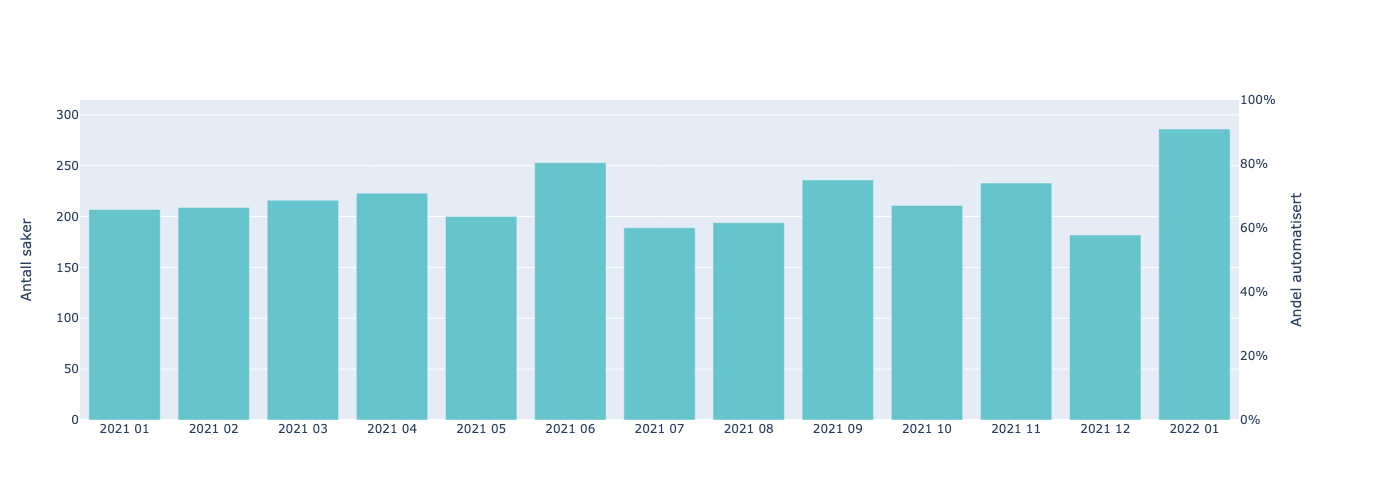

In [187]:
fig_automatisering_total1 = plot_automatisering1(df_auto)
fig_automatisering_total1.show()

## Automatisering på selvbetjente saker

In [188]:
df_selvbetjent = df_ap[_selvbetjent].groupby(["År-måned", "Automatiseringsgrad"], as_index=False)[["Antall innkomne saker"]].sum()
df_selvbetjent = add_total_and_andel(df_selvbetjent)

#fig_selvbetjent = px.bar(df_selvbetjent, x="År-måned", y="Andel", color="Automatiseringsgrad", color_discrete_sequence=automatiserings_colors)
#fig_selvbetjent.update_layout(yaxis_tickformat = '.0%')
#fig_selvbetjent.show()

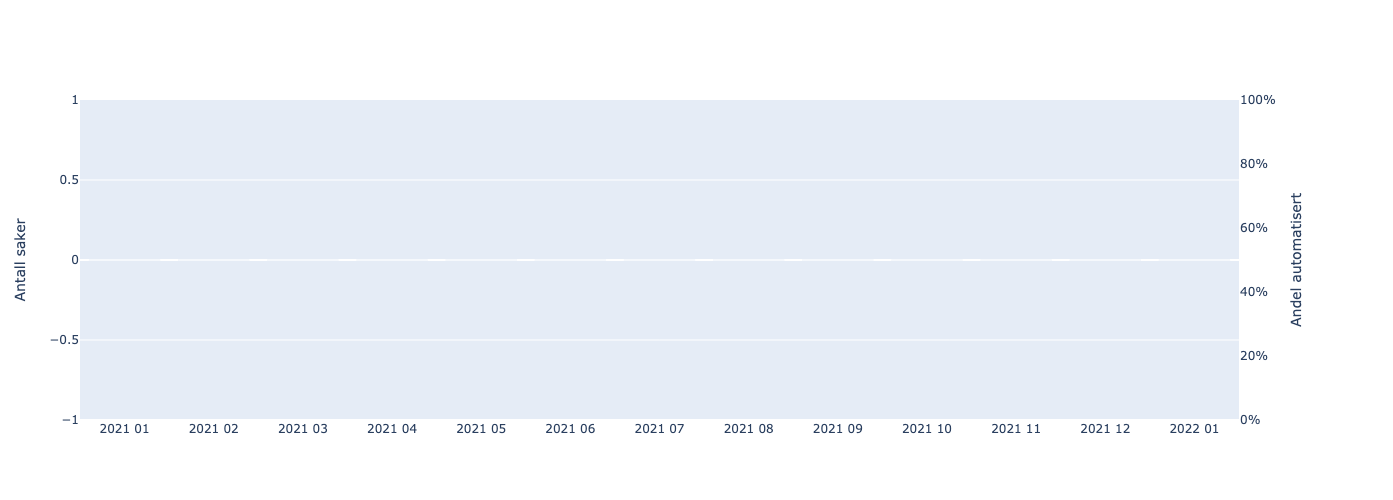

In [189]:
fig_automatisering_selvbetjent1 = plot_automatisering1(df_selvbetjent)
fig_automatisering_selvbetjent1.show()

## Automatisering på ikke selvbetjente saker

In [190]:
df_ikke_selvbetjent = df_ap[~_selvbetjent].groupby(["År-måned", "Automatiseringsgrad"], as_index=False)[["Antall innkomne saker"]].sum()
df_ikke_selvbetjent = add_total_and_andel(df_ikke_selvbetjent)

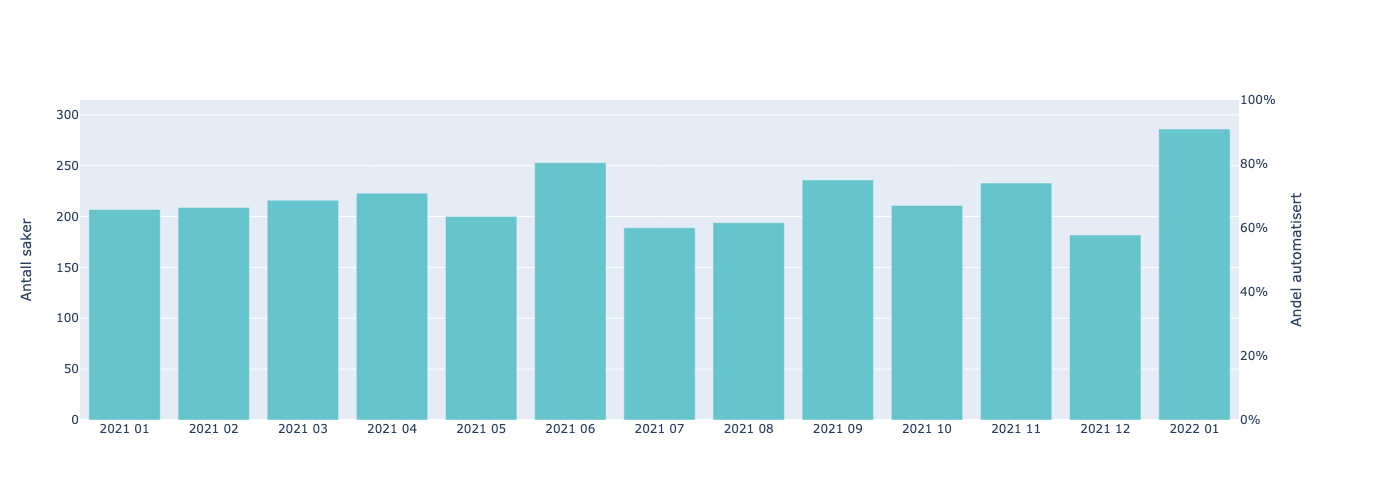

In [191]:
fig_automatisering_ikke_selvbetjent1 = plot_automatisering1(df_ikke_selvbetjent)
fig_automatisering_ikke_selvbetjent1.show()

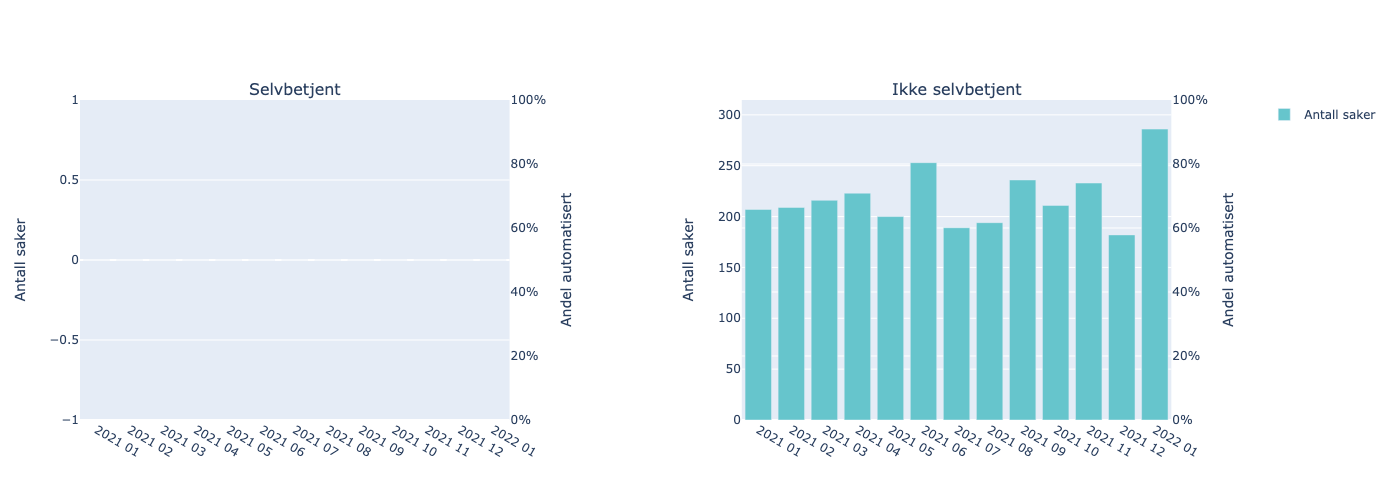

In [192]:
titles = ('Selvbetjent', 'Ikke selvbetjent')
fig_automatisering_selvbetjening = plot_automatisering_subplots([[df_selvbetjent, df_ikke_selvbetjent]], titles)
fig_automatisering_selvbetjening.show()

## Automatiseringsgrad Utlandstilsnitt

In [193]:
df_automatisering_innland = df_ap[_innland].groupby(["År-måned", "Automatiseringsgrad"], as_index=False)["Antall innkomne saker"].sum()
df_automatisering_innland = add_total_and_andel(df_automatisering_innland)

In [194]:
df_automatisering_utland = df_ap[~_innland].groupby(["År-måned", "Automatiseringsgrad"], as_index=False)["Antall innkomne saker"].sum()
df_automatisering_utland = add_total_and_andel(df_automatisering_utland)

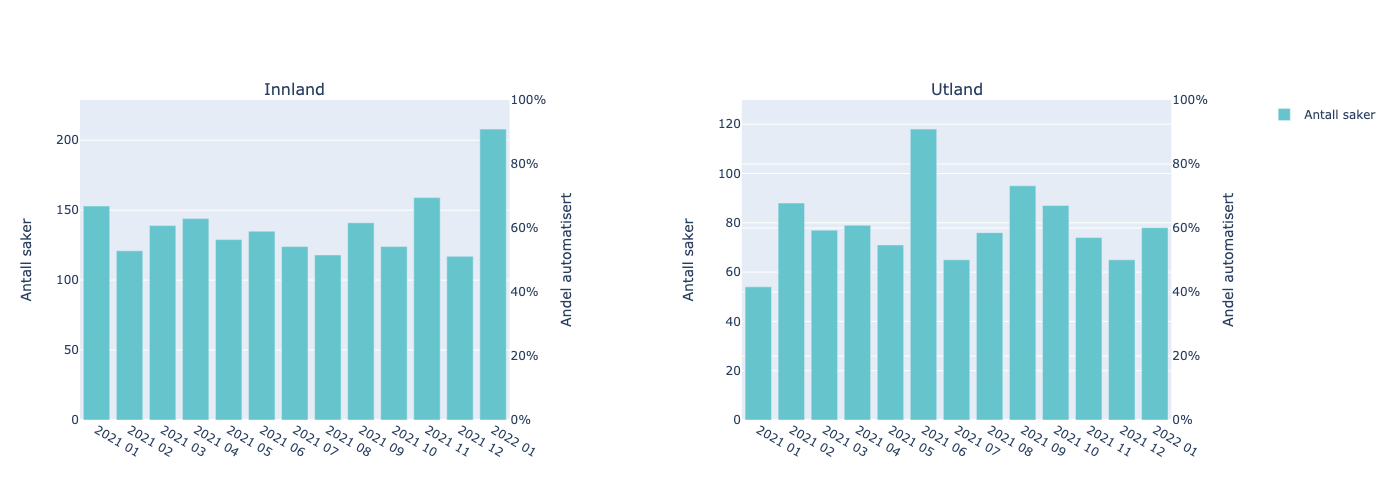

In [195]:
fig_automatisering_utlandstilsnitt = plot_automatisering_subplots([[df_automatisering_innland, df_automatisering_utland]], titles=["Innland", "Utland"])
fig_automatisering_utlandstilsnitt.show()

# Selvbetjeningsgrad

In [196]:
def plot_selvbetjening1(df, box_color=px.colors.qualitative.Pastel[2]):

    df_tot = df.groupby("År-måned", as_index=False)["Antall innkomne saker"].sum()
    
    _selvbetjent = df["Selvbetjening"] == "Selvbetjent"
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(go.Bar(x=df_tot["År-måned"], y=df_tot["Antall innkomne saker"], 
                         name="Antall saker", marker_color=box_color), 
                  secondary_y=False)
    
    fig.add_trace(go.Scatter(x=df[_selvbetjent]["År-måned"], y=df[_selvbetjent]["Andel"], 
                             name="Selvbetjening", mode="lines+markers",
                             line={'dash': 'solid', 'color': 'black'}),
                  
                  secondary_y=True)
    
    fig.update_yaxes(title_text="Andel selvbetjening", secondary_y=True, range=[0,1], tickformat='.0%')
    fig.update_yaxes(title_text="Antall saker", range=[0,max(df_tot["Antall innkomne saker"])*1.1], secondary_y=False)
    fig.layout.yaxis2.showgrid = False
    fig.update_layout(
        autosize=False,
        width=1300,
        height=500,)    
    return fig

In [197]:
def plot_selvbetjening2(df):
    
    df_tot = df.groupby("År-måned", as_index=False)["Antall innkomne saker"].sum()
    
    _selvbetjent = df["Selvbetjening"] == "Selvbetjent"
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(go.Scatter(x=df_tot["År-måned"], y=df_tot["Antall innkomne saker"], mode="lines", marker_color="rgb(0,0,0)", name="Totalt antall saker"), secondary_y=True)
    
    fig.add_trace(go.Bar(x=df[_selvbetjent]["År-måned"], y=df[_selvbetjent]["Andel"], marker_color=automatiserings_colors[0], name="Selvbetjent"), secondary_y=False)
    fig.add_trace(go.Bar(x=df[~_selvbetjent]["År-måned"], y=df[~_selvbetjent]["Andel"], marker_color=automatiserings_colors[2], name="Ikke selvbetjent"), secondary_y=False)
    
    fig.update_layout(yaxis_tickformat = '.0%', barmode='stack')
    fig.update_yaxes(title_text="Andel selvbetjening", secondary_y=False)
    fig.update_yaxes(title_text="Antall saker", range=[0,max(df_tot["Antall innkomne saker"])*1.1], secondary_y=True)
    
    return fig

In [198]:
def plot_selvbetjening_subplots(df_list, titles, box_color=px.colors.qualitative.Pastel[2]):
    '''
    '''
    N = len(df_list)
    M = len(df_list[0])
    fig = make_subplots(rows=N, cols=M, specs=[[{"secondary_y": True} for i in range(N*M)]], subplot_titles=titles)
    showlegend = True
    for i in range(N):
        for j in range(M):
            if i+j > 0:
                showlegend = False
            df = df_list[i][j]
            df_tot = df.groupby("År-måned", as_index=False)["Antall innkomne saker"].sum()

            _selvbetjent = df["Selvbetjening"] == "Selvbetjent"
            
            fig.add_trace(go.Bar(x=df_tot["År-måned"], y=df_tot["Antall innkomne saker"], 
                         name="Antall saker", legendgroup="Antall saker", showlegend=showlegend, marker_color=box_color), 
                  row=i+1, col=j+1, secondary_y=False)
    
            fig.add_trace(go.Scatter(x=df[_selvbetjent]["År-måned"], y=df[_selvbetjent]["Andel"], 
                             name="Selvbetjening", legendgroup="Selvbetjening", showlegend=showlegend, mode="lines+markers",
                             line={'dash': 'solid', 'color': 'black'}),
                  row=i+1, col=j+1, secondary_y=True)
            
            fig.update_yaxes(title_text="Andel selvbetjening", secondary_y=True, range=[0,1], tickformat='.0%', row=i+1, col=j+1)
            fig.update_yaxes(title_text="Antall saker", range=[0,max(df_tot["Antall innkomne saker"])*1.1], secondary_y=False, row=i+1, col=j+1)
    
    fig.layout.yaxis2.showgrid = False
    fig.update_layout(
        autosize=False,
        width=1300,
        height=500,)
    return fig

## Total selvbetjeningsgrad

In [199]:
df_andel_selvbetjening = df_ap.groupby(["År-måned", "Selvbetjening"], as_index=False)["Antall innkomne saker"].sum()
df_andel_selvbetjening = add_total_and_andel(df_andel_selvbetjening)

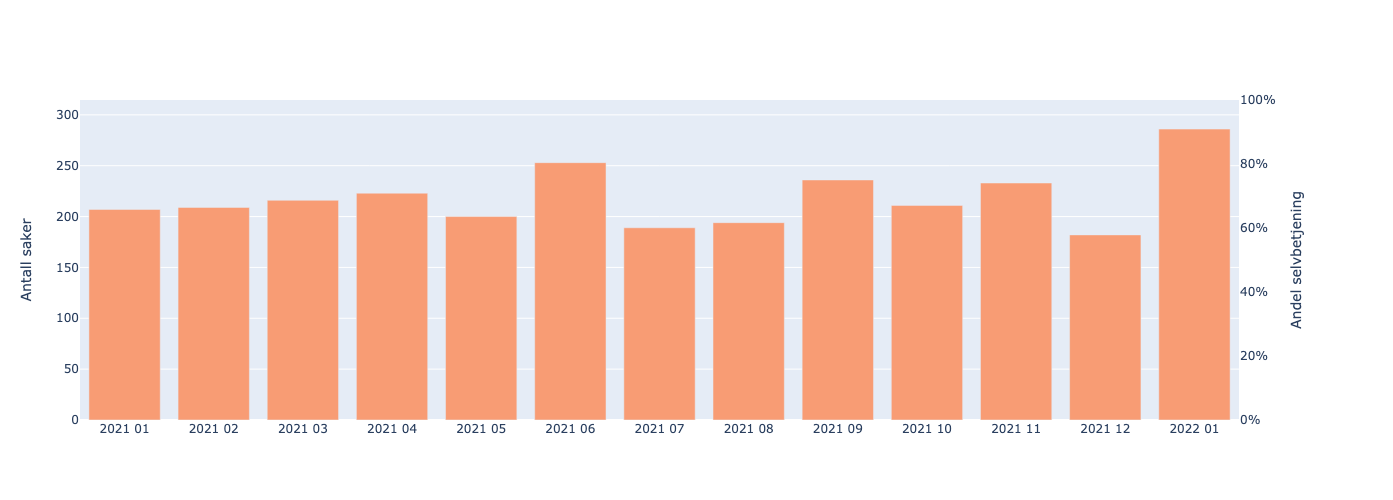

In [200]:
fig_selvbetjening_total1 = plot_selvbetjening1(df_andel_selvbetjening)
fig_selvbetjening_total1.show()

## Selvbetjening innland

In [201]:
df_selvbetjening_innland = df_ap[_innland].groupby(["År-måned", "Selvbetjening"], as_index=False)["Antall innkomne saker"].sum()
df_selvbetjening_innland = add_total_and_andel(df_selvbetjening_innland)

## Selvbetjening utland

In [202]:
df_selvbetjening_utland = df_ap[~_innland].groupby(["År-måned", "Selvbetjening"], as_index=False)["Antall innkomne saker"].sum()
df_selvbetjening_utland = add_total_and_andel(df_selvbetjening_utland)

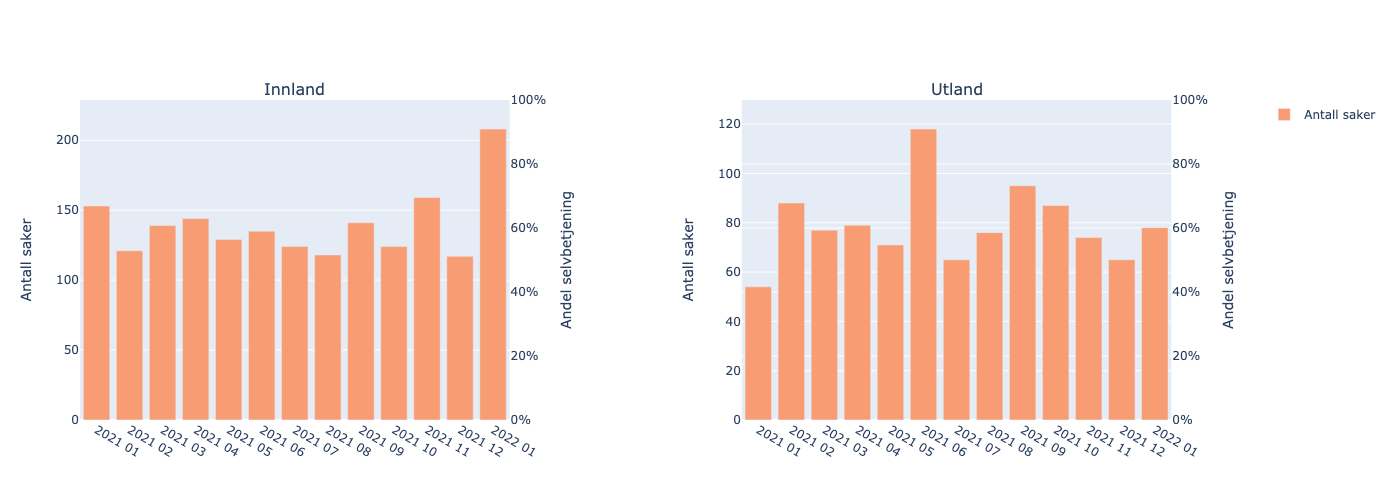

In [203]:
fig_selvbetjening_utlandstilsnitt = plot_selvbetjening_subplots([[df_selvbetjening_innland, df_selvbetjening_utland]], ["Innland", "Utland"])
fig_selvbetjening_utlandstilsnitt.show()

In [204]:
innledning = f"Statistikk på automatiserings- og selvbetjeningsgrad for førstegangsbehandling av {ytelse}. Data er basert på rapporten PSAK120. Saker opprettet av batch er eksludert."

In [205]:
from datastory import DataStory

In [206]:
ds = DataStory(f"Automatiserings- og Selvbetjeningsgrad for {ytelse}")

ds.markdown(innledning)

ds.header("Automatiseringsgrad", level=1)
ds.markdown("Automatiseringsgrad på alle nye saker. Del-automatisk henviser til saker hvor deler av saksbehandlingen ble gjort automatisk.")
ds.plotly(fig_automatisering_total1.to_json())

ds.header("Automatiseringsgrad selvbetjening", level=2)
ds.plotly(fig_automatisering_selvbetjening.to_json())

ds.header("Automatiseringsgrad utlandstilsnitt", level=2)
ds.plotly(fig_automatisering_utlandstilsnitt.to_json())

ds.header("Selvbetjeningsgrad", level=1)
ds.markdown("Selvbetjeningsgrad på alle nye saker.")
ds.plotly(fig_selvbetjening_total1.to_json())

ds.header("Selvbetjeningsgrad utlandstilsnitt", level=2)
ds.plotly(fig_selvbetjening_utlandstilsnitt.to_json())

In [207]:
ds.publish(url="https://nada.ekstern.dev.nav.no/api") #dev
#ds.publish(url="https://nada.intern.nav.no/api") #prod
#ds.update(url="https://nada.ekstern.dev.nav.no/api", token='1f79f29a-b9a6-48d4-8514-96a2c45ef319')

<IPython.core.display.Javascript object>

'https://data.dev.intern.nav.no/story/draft/7ba5ec71-5925-4e75-9ff7-b33bce2e05c6'